In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

In [2]:
data = pd.read_csv("tests/data/inhaler.csv")
data["rating"] = pd.Categorical(data["rating"], categories=[1, 2, 3, 4])
data.head()

,subject,rating,treat,period,carry
0,1,1,0.5,0.5,0
1,2,1,0.5,0.5,0
2,3,1,0.5,0.5,0
3,4,1,0.5,0.5,0
4,5,1,0.5,0.5,0


In [3]:
with pm.Model() as model:
    threshold = pm.Normal(
        "threshold", 
        mu=(-1, 0, 1),
        transform=pm.distributions.transforms.univariate_ordered
    )

    treat = pm.Normal("treat")
    period = pm.Normal("period")
    carry = pm.Normal("carry")

    eta = (
        treat * data["treat"].to_numpy() 
        + period * data["period"].to_numpy() 
        + carry * data["carry"].to_numpy() 
    )

    # like brms
    eta_shifted = threshold - pt.shape_padright(eta)
    probabilities = pm.math.sigmoid(eta_shifted)

    ps = pt.concatenate(
        [
            pt.shape_padright(probabilities[..., 0]), 
            probabilities[..., 1:] - probabilities[..., :-1], 
            pt.shape_padright(1 - probabilities[..., -1])
        ], 
        axis=-1
    )

    pm.Categorical("response", p=ps, observed=data["rating"].cat.codes.to_numpy())
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [threshold, treat, period, carry]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [4]:
az.summary(idata, var_names=["threshold", "treat", "period", "carry"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold[0],0.503,0.087,0.341,0.667,0.002,0.001,2669.0,1728.0,1.0
threshold[1],2.998,0.182,2.647,3.328,0.003,0.002,2778.0,1655.0,1.0
threshold[2],4.147,0.308,3.611,4.731,0.007,0.005,2157.0,1608.0,1.0
treat,-0.734,0.231,-1.180,-0.315,0.006,0.004,1578.0,1034.0,1.0
period,0.173,0.168,-0.146,0.471,0.004,0.003,2166.0,1509.0,1.0
carry,-0.233,0.167,-0.535,0.089,0.004,0.003,1460.0,1476.0,1.0


In [5]:
model = bmb.Model("rating ~ period + carry + treat", data, family="cumulative")
model

/home/tomas/Desktop/bambinos/bambi/bambi/formula.py:102: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")


       Formula: rating ~ period + carry + treat
        Family: cumulative
          Link: p = logit
  Observations: 572
        Priors: 
    target = p
        Common-level effects
            period ~ Normal(mu: 0.0, sigma: 5.0)
            carry ~ Normal(mu: 0.0, sigma: 3.5356)
            treat ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            rating_threshold ~ Normal(mu: [-2.  0.  2.], sigma: 1.0, transform: ordered)

In [6]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rating_threshold, period, carry, treat]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,0.185,0.172,-0.155,0.489,0.004,0.003,2332.0,1645.0,1.0
carry,-0.219,0.172,-0.525,0.115,0.004,0.003,1531.0,1604.0,1.0
treat,-0.783,0.234,-1.227,-0.356,0.006,0.004,1580.0,1335.0,1.0
rating_threshold[0],0.506,0.090,0.344,0.686,0.002,0.001,2437.0,1451.0,1.0
rating_threshold[1],3.030,0.182,2.696,3.366,0.004,0.002,2732.0,1664.0,1.0
rating_threshold[2],4.239,0.319,3.656,4.833,0.007,0.005,2168.0,1603.0,1.0


**WORKS!!!**

---

In [8]:
with pm.Model() as model:
    threshold = pm.Normal("threshold", mu=(-1, 0, 1))

    treat = pm.Normal("treat")
    period = pm.Normal("period")
    carry = pm.Normal("carry")

    eta = (
        treat * data["treat"].to_numpy() 
        + period * data["period"].to_numpy() 
        + carry * data["carry"].to_numpy() 
    )

    eta_shifted = threshold - pt.shape_padright(eta)
    probabilities = pm.math.sigmoid(eta_shifted)
    
    n_columns = probabilities.type.shape[-1]
    ps = pt.concatenate(
        [
            pt.shape_padright(probabilities[..., 0]),
            *[
                pt.shape_padright(
                    probabilities[..., j] * pt.prod(1 - probabilities[..., :j], axis=-1)
                )
                for j in range(1, n_columns)
            ],
            pt.shape_padright(pt.prod(1 - probabilities, axis=-1))
        ],
        axis=-1
    )
    pm.Categorical("response", p=ps, observed=data["rating"].cat.codes.to_numpy())
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [threshold, treat, period, carry]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [9]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold[0],0.539,0.092,0.365,0.707,0.002,0.001,2435.0,1576.0,1.0
threshold[1],2.170,0.206,1.799,2.561,0.004,0.003,2401.0,1487.0,1.0
threshold[2],1.113,0.403,0.307,1.810,0.008,0.006,2441.0,1488.0,1.0
treat,-0.717,0.229,-1.162,-0.309,0.005,0.004,1908.0,1390.0,1.0
period,0.195,0.162,-0.102,0.493,0.003,0.003,2263.0,1329.0,1.0
carry,-0.219,0.164,-0.523,0.087,0.004,0.003,2013.0,1390.0,1.0


In [10]:
model = bmb.Model("rating ~ period + carry + treat", data, family="sratio")
model

/home/tomas/Desktop/bambinos/bambi/bambi/formula.py:102: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")


       Formula: rating ~ period + carry + treat
        Family: sratio
          Link: p = logit
  Observations: 572
        Priors: 
    target = p
        Common-level effects
            period ~ Normal(mu: 0.0, sigma: 5.0)
            carry ~ Normal(mu: 0.0, sigma: 3.5356)
            treat ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            rating_threshold ~ Normal(mu: [-2.  0.  2.], sigma: 1.0)

In [11]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rating_threshold, period, carry, treat]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [12]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rating_threshold[0],0.531,0.087,0.380,0.706,0.002,0.001,2869.0,1416.0,1.0
rating_threshold[1],2.184,0.208,1.797,2.594,0.004,0.003,2194.0,1095.0,1.0
rating_threshold[2],1.275,0.409,0.535,2.047,0.008,0.006,2521.0,1554.0,1.0
period,0.218,0.165,-0.080,0.533,0.004,0.003,1956.0,1356.0,1.0
carry,-0.217,0.162,-0.532,0.074,0.004,0.003,1979.0,1437.0,1.0
treat,-0.746,0.223,-1.148,-0.337,0.005,0.004,1878.0,1357.0,1.0


```r
Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept[1]     0.55      0.09     0.38     0.73 1.00     5196     3204
Intercept[2]     2.26      0.22     1.84     2.71 1.00     5275     2661
Intercept[3]     1.09      0.43     0.27     1.98 1.00     5299     2562
treat           -0.75      0.22    -1.19    -0.31 1.00     3648     2724
period           0.21      0.17    -0.12     0.53 1.00     5490     3392
carry           -0.22      0.17    -0.53     0.11 1.00     3726     2606
```

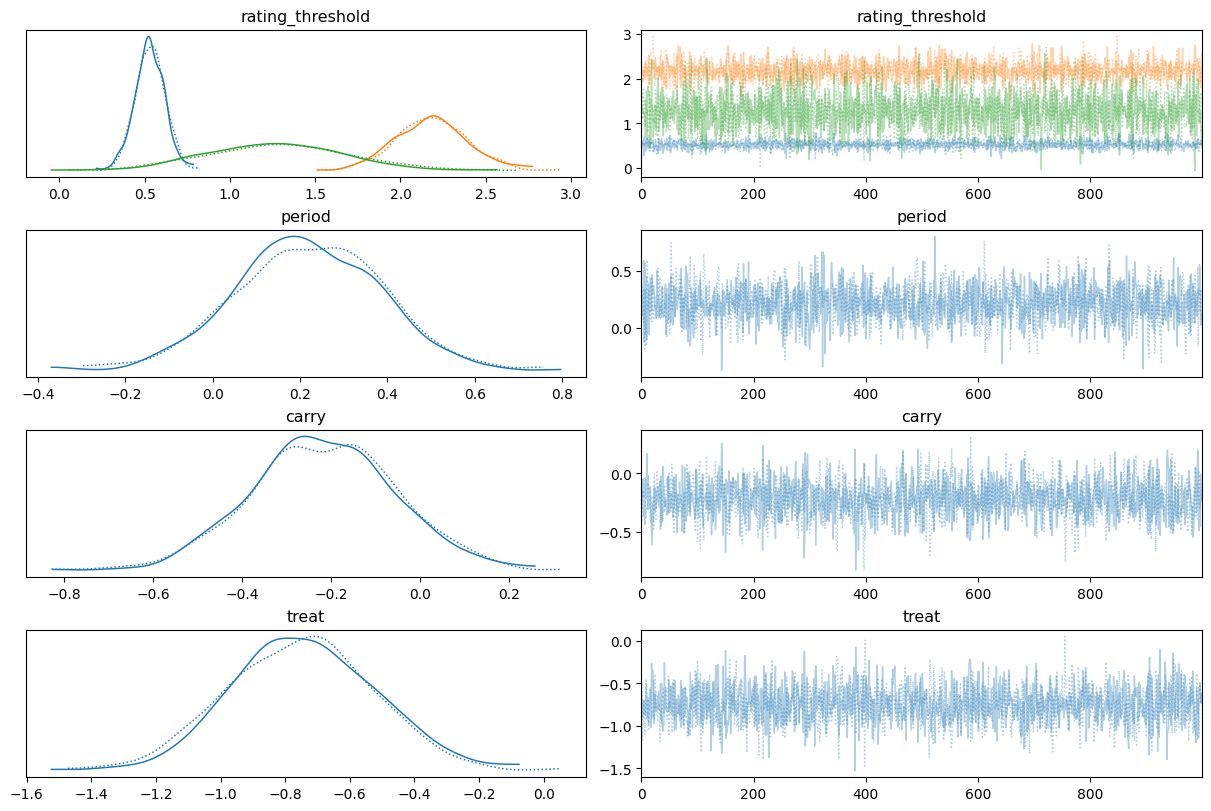

In [14]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});

**WORKS!**

---

In [4]:
df_stemcell = pd.read_csv("stemcell.csv")

In [5]:
df_stemcell.head()

,belief,rating,gender
0,fundamentalist,1,female
1,fundamentalist,1,female
2,fundamentalist,1,female
3,fundamentalist,1,female
4,fundamentalist,1,female


In [6]:
df_stemcell["rating"] = np.abs(df_stemcell["rating"] - 5)
df_stemcell["belief"] = pd.Categorical(df_stemcell["belief"], categories=["moderate", "fundamentalist", "liberal"], ordered=True)

In [7]:
df_stemcell.head()

,belief,rating,gender
0,fundamentalist,4,female
1,fundamentalist,4,female
2,fundamentalist,4,female
3,fundamentalist,4,female
4,fundamentalist,4,female


In [100]:
belief_idx = df_stemcell["belief"].cat.codes.to_numpy()
beliefs = ["moderate", "fundamentalist", "liberal"]

coords = {"beliefs": beliefs[1:]}
with pm.Model(coords=coords) as model:
    threshold = pm.Normal(
        "threshold", 
        mu=(-1, 0, 1),
        transform=pm.distributions.transforms.univariate_ordered
    )

    belief = pm.Normal("belief", dims="beliefs")
    belief = pt.concatenate([np.zeros(1), belief])

    eta = belief[belief_idx]

    # like brms
    eta_shifted = threshold - pt.shape_padright(eta)
    probabilities = pm.math.sigmoid(eta_shifted.T).T

    ps = pt.concatenate(
        [
            pt.shape_padright(probabilities[..., 0]), 
            probabilities[..., 1:] - probabilities[..., :-1], 
            pt.shape_padright(1 - probabilities[..., -1])
        ], 
        axis=-1
    )

    pm.Categorical("response", p=ps, observed=(df_stemcell["rating"] - 1).to_numpy())
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [threshold, belief]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [101]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
belief[fundamentalist],-0.388,0.160,-0.687,-0.092,0.004,0.003,1462.0,1414.0,1.0
belief[liberal],0.578,0.156,0.274,0.862,0.004,0.003,1607.0,1351.0,1.0
threshold[0],-2.130,0.146,-2.405,-1.859,0.005,0.003,1010.0,1126.0,1.0
threshold[1],-1.020,0.115,-1.229,-0.801,0.003,0.002,1326.0,1576.0,1.0
threshold[2],0.964,0.117,0.736,1.176,0.003,0.002,1498.0,1557.0,1.0


In [8]:
df_stemcell["rating"] = pd.Categorical(df_stemcell["rating"], categories=[4, 3, 2, 1])

In [9]:
bmb_stemcell = bmb.Model("rating ~ 1 + belief", df_stemcell, family="cumulative", link="probit")
bmb_stemcell

/home/tomas/Desktop/bambinos/bambi/bambi/formula.py:102: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")


       Formula: rating ~ 1 + belief
        Family: cumulative
          Link: p = probit
  Observations: 829
        Priors: 
    target = p
        Common-level effects
            belief ~ Normal(mu: [0. 0.], sigma: [5.345  5.2462])
        
        Auxiliary parameters
            rating_threshold ~ Normal(mu: [-2.  0.  2.], sigma: 1.0, transform: ordered)

In [10]:
idata = bmb_stemcell.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rating_threshold, belief]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [11]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
belief[fundamentalist],-0.239,0.093,-0.420,-0.076,0.003,0.002,1267.0,1393.0,1.0
belief[liberal],0.320,0.094,0.145,0.494,0.003,0.002,1204.0,1251.0,1.0
rating_threshold[0],-1.255,0.082,-1.401,-1.095,0.003,0.002,990.0,1095.0,1.0
rating_threshold[1],-0.633,0.074,-0.758,-0.486,0.002,0.002,1142.0,1246.0,1.0
rating_threshold[2],0.582,0.070,0.451,0.715,0.002,0.001,1248.0,1413.0,1.0


```r
Population-Level Effects:
Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept[1] -1.25 0.08 -1.42 -1.10 2681 1.00
Intercept[2] -0.64 0.07 -0.78 -0.50 3629 1.00
Intercept[3] 0.57 0.07 0.43 0.71 3461 1.00
belieffundamentalist -0.24 0.09 -0.43 -0.06 3420 1.00
beliefliberal 0.31 0.09 0.13 0.50 3381 1.00
```

---

In [20]:
df_marriage = pd.read_csv("marriage.csv")
print(df_marriage.shape)
df_marriage.head()

(1228, 5)


,ID,together,age,years,divorced
0,1,yes,19,9,True
1,2,yes,22,9,False
2,3,yes,20,5,False
3,4,yes,22,2,False
4,5,yes,25,6,False


In [21]:
df_marriage = df_marriage[df_marriage.divorced == True].reset_index(drop=True)

In [22]:
df_marriage.shape

(616, 5)

In [27]:
np.sort(df_marriage["years"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24, 27])

In [29]:
df_marriage["years"] = pd.Categorical(df_marriage["years"], categories=np.arange(27) + 1)

In [30]:
bmb_marriage = bmb.Model("years ~ 1 + age + together", df_marriage, family="sratio", link="cloglog")
bmb_marriage

/home/tomas/Desktop/bambinos/bambi/bambi/formula.py:102: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")


       Formula: years ~ 1 + age + together
        Family: sratio
          Link: p = cloglog
  Observations: 616
        Priors: 
    target = p
        Common-level effects
            age ~ Normal(mu: 0.0, sigma: 0.6517)
            together ~ Normal(mu: 0.0, sigma: 5.0817)
        
        Auxiliary parameters
            years_threshold ~ Normal(mu: [-2.   -1.82 -1.64 -1.45 -1.27 -1.09 -0.91 -0.73 -0.55 -0.36 -0.18
                0.
              0.18  0.36  0.55  0.73  0.91  1.09  1.27  1.45  1.64  1.82  2.  ], sigma: 1.0)

In [31]:
idata = bmb_marriage.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [years_threshold, age, together]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 361 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [32]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
years_threshold[0],-2.226,0.220,-2.632,-1.836,0.010,0.007,504.0,991.0,1.0
years_threshold[1],-1.874,0.215,-2.282,-1.472,0.010,0.007,476.0,816.0,1.0
years_threshold[2],-1.786,0.211,-2.176,-1.387,0.010,0.007,442.0,903.0,1.0
years_threshold[3],-1.796,0.220,-2.188,-1.381,0.010,0.007,502.0,950.0,1.0
years_threshold[4],-1.568,0.215,-1.945,-1.148,0.010,0.007,514.0,988.0,1.0
years_threshold[5],-1.161,0.207,-1.579,-0.795,0.010,0.007,441.0,809.0,1.0
years_threshold[6],-1.242,0.219,-1.671,-0.844,0.010,0.007,508.0,956.0,1.0
years_threshold[7],-1.363,0.236,-1.814,-0.921,0.011,0.008,472.0,824.0,1.0
years_threshold[8],-1.415,0.245,-1.846,-0.935,0.010,0.007,573.0,1014.0,1.0
years_threshold[9],-1.009,0.240,-1.488,-0.580,0.010,0.007,528.0,931.0,1.0


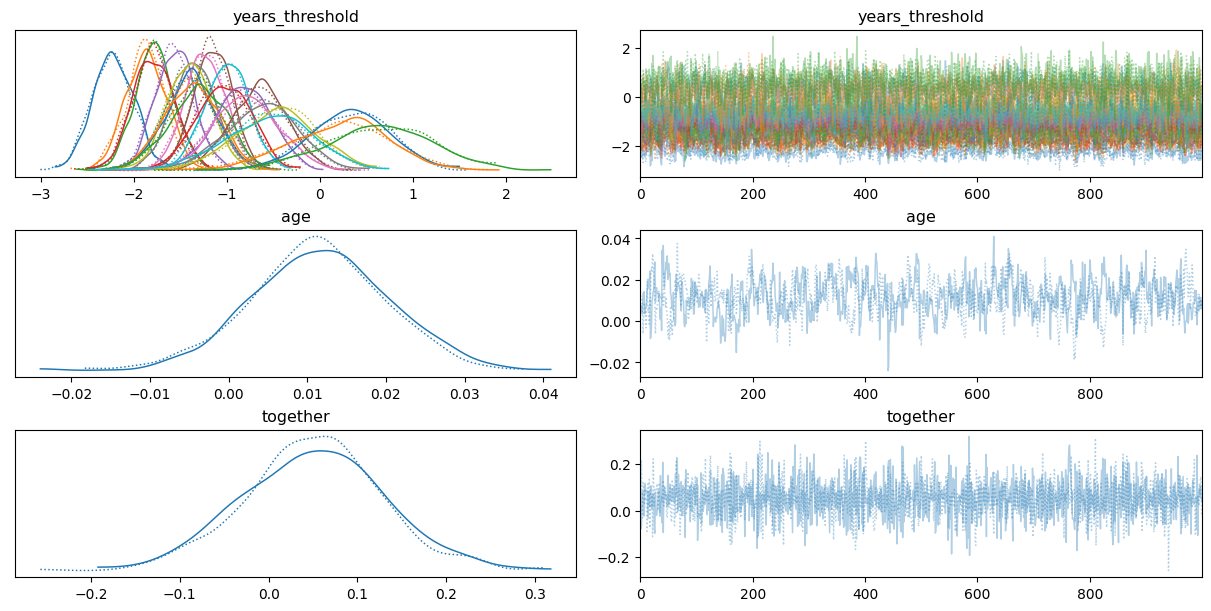

In [33]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});

# To Do

* Proper dims for threshold parameter
* Verify it's possible to modify the prior for the threshold parameter
* Verify we can compute predictions
* Implement tests
* Q: Should Bambi convert the response variable type automatically?